In [1]:
import cv2
import sqlite3 
import json
import pickle
import matplotlib.pyplot as plt
from ultralytics import YOLO

In [4]:
# load json
json_path = '../outputs/yolo_detections_all_videos.json'
with open(json_path, 'r') as f:
    yolo_detections = json.load(f)
    
images = yolo_detections['images']

## Visualize Yolo Output

In [2]:
# Extract a specific frame from a video
def get_frame(
    video_path = str, 
    frame_number = int):
    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    ret, frame = cap.read()
    cap.release()
    if not ret:
        raise ValueError(f"Frame number {frame_number} could not be retrieved.")
    return frame
    
def display_yolo_detections(frame_id = str):
    base_filename = frame_id.rsplit('_', 1)[0]
    video_name = f"{base_filename}.MP4"
    video_path = '../../../ProcessedData/videos/' + video_name
    frame_int = int(frame_id.split('_')[-1])
    frame = get_frame(video_path, frame_int)
    # Convert frame to RGB
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    # Get frame dimensions
    frame_height, frame_width = frame.shape[:2]
    
    # Get detections for the frame
    detections = [image['annotations'] for image in images if image['image_id'] == f'{frame_id}.jpg']

    # Check if detections list is empty or if the first element is empty
    if len(detections) == 0 or len(detections[0]) == 0:
        print(f'No detections found for {frame_id}.jpg')
        # Convert frame back to RGB for display
        plt.figure(figsize=(20, 16))
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        plt.imshow(rgb_frame)
        plt.axis('off')
        plt.show()
        return
    
    for detection in detections[0]:
        cls = detection['class']
        bbox = detection['bbox']
        confidence = detection['confidence']
        
        x_center, y_center, width, height = bbox
        # Convert normalized coordinates to pixel values
        x1 = int((x_center - width / 2) * frame_width)
        y1 = int((y_center - height / 2) * frame_height)
        x2 = int((x_center + width / 2) * frame_width)
        y2 = int((y_center + height / 2) * frame_height)
    
        # Draw bounding boxes on the frame
        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 0, 139), 5)
        
        label = f"person: {confidence:.2f}"
        print(label)
        cv2.putText(frame, label, (x1, y1), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 139), 5)
        
    # Convert frame back to RGB for display
    plt.figure(figsize=(20, 16))
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    plt.imshow(rgb_frame)
    plt.axis('off')
    plt.show()

person: 0.66
person: 0.59
person: 0.55
person: 0.36
person: 0.32
person: 0.29
person: 0.28


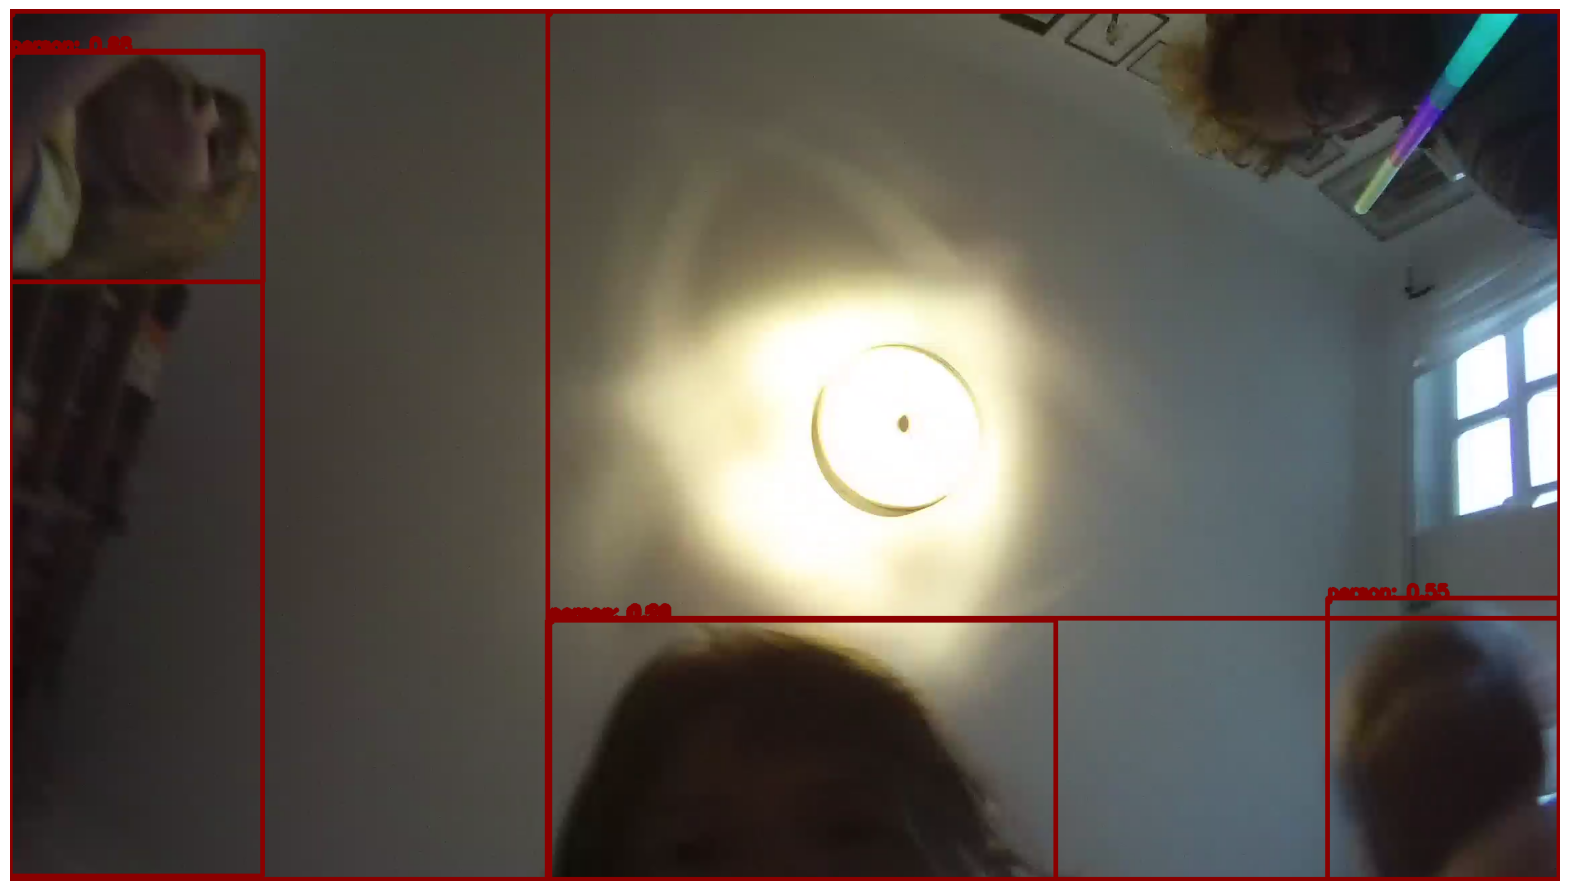

In [7]:
display_yolo_detections('quantex_at_home_id271700_2023_06_08_01_000960')

## Run Yolo Model on Single Image

In [13]:
model = YOLO('../../../models/yolov8_trained.pt')

def get_frame(
    video_path = str, 
    frame_number = int):
    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    ret, frame = cap.read()
    cap.release()
    if not ret:
        raise ValueError(f"Frame number {frame_number} could not be retrieved.")
    return frame

def display_yolo_detections_on_single_image(frame_id = str, iou_threshold = 0.35):
    base_filename = frame_id.rsplit('_', 1)[0]
    video_name = f"{base_filename}.MP4"
    video_path = '../../../ProcessedData/videos/' + video_name
    frame_int = int(frame_id.split('_')[-1])
    frame = get_frame(video_path, frame_int)
    # Convert frame to RGB
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    # Get frame dimensions
    frame_height, frame_width = frame.shape[:2]
    
    # Get detections for the frame
    detections = model(frame, iou=iou_threshold)

    # Check if detections list is empty or if the first element is empty
    if len(detections[0]) == 0 or len(detections[0].boxes) == 0:
        print(f'No detections found for {frame_id}.jpg')
        # Convert frame back to RGB for display
        plt.figure(figsize=(20, 16))
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        plt.imshow(rgb_frame)
        plt.axis('off')
        plt.show()
        return
    
    # Add the annotations for the detected objects
    for boxes in detections[0].boxes:
        # Get the bounding box coordinates (x center, y center, width, height) normalized to the image size
        x_center, y_center, width, height = boxes.xywhn[0]
        confidence = boxes.conf[0]
        # Get the category ID and name
        # Convert normalized coordinates to pixel values
        x1 = int((x_center - width / 2) * frame_width)
        y1 = int((y_center - height / 2) * frame_height)
        x2 = int((x_center + width / 2) * frame_width)
        y2 = int((y_center + height / 2) * frame_height)
    
        # Draw bounding boxes on the frame
        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 0, 139), 5)
        
        label = f"person: {confidence:.2f}"
        cv2.putText(frame, f"{label}", (x1, y1), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 139), 5)
        
    # Convert frame back to RGB for display
    plt.figure(figsize=(20, 16))
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    plt.imshow(rgb_frame)
    plt.axis('off')
    plt.show()



0: 384x640 6 persons, 22.4ms
Speed: 3.6ms preprocess, 22.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


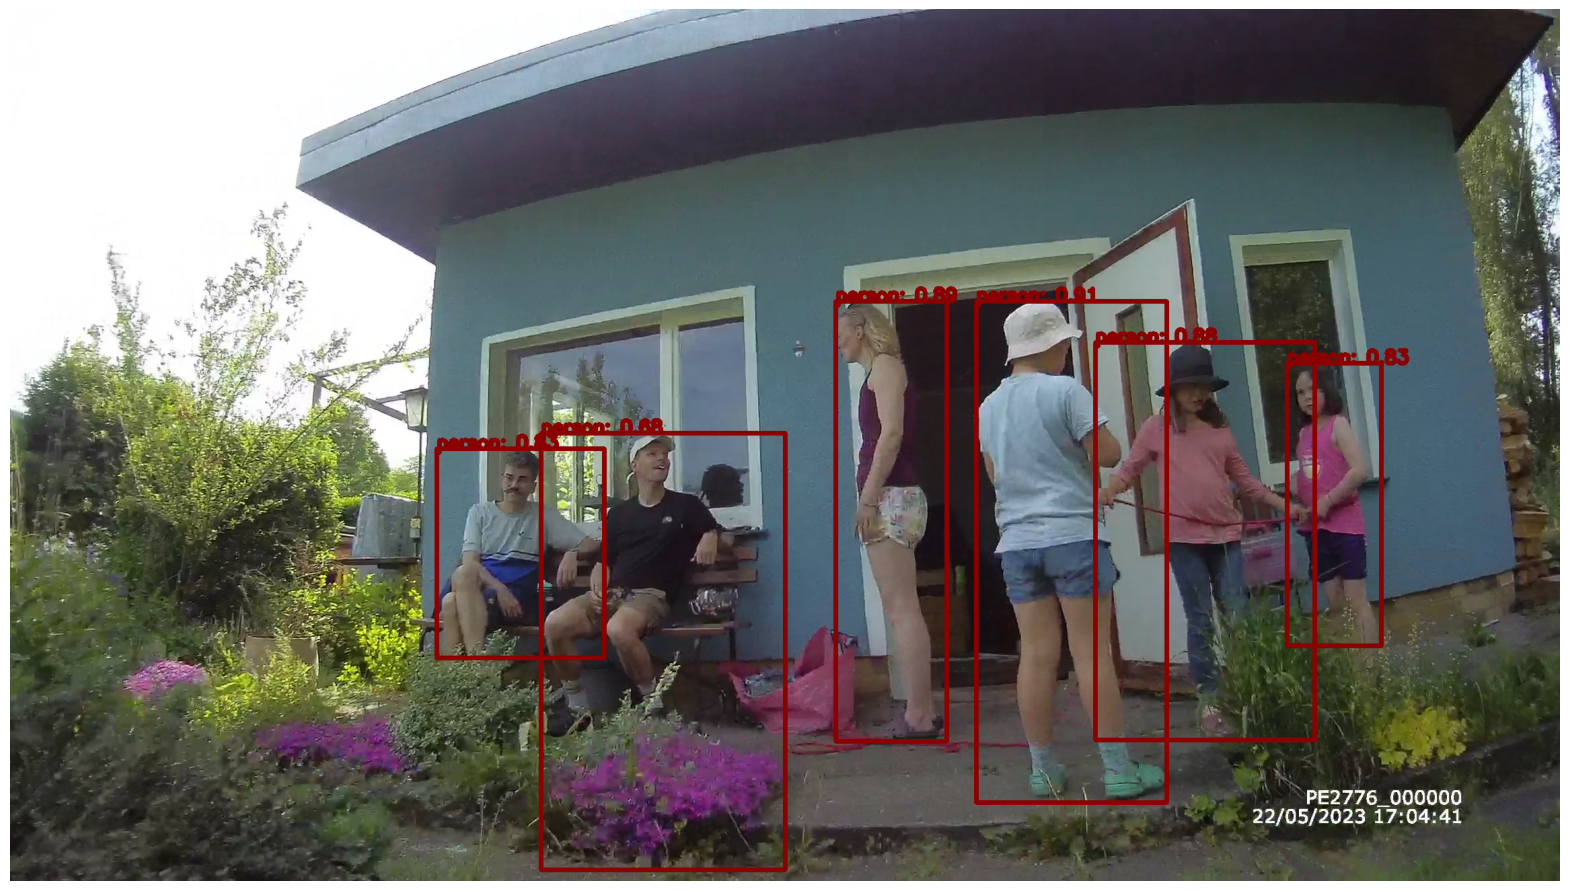

In [25]:
display_yolo_detections_on_single_image('quantex_at_home_id264041_2023_05_22_05_053310', iou_threshold=0.35)

## Count frequency of person detections

In [6]:
# load json
json_path = '../outputs/yolo_detections_all_videos.json'
with open(json_path, 'r') as f:
    yolo_detections_train = json.load(f)
    
images = yolo_detections_train['images']

# Initialize counters
total_images = len(images)
detection_counts = {}  # Dictionary to hold counts of images with 0, 1, 2, ... detections

# Iterate through the data
for image_data in images:
    # Count the number of detections for the current image
    num_detections = len(image_data['annotations'])
    image_id = image_data['image_id']
    
    # Update the detection counts dictionary
    if num_detections in detection_counts:
        detection_counts[num_detections]['count'] += 1
        detection_counts[num_detections]['image_ids'].append(image_id)
    else:
        detection_counts[num_detections] = {'count': 1, 'image_ids': [image_id]}

# Display the results
print(f"Total number of images: {total_images}")
for num_detections, data in sorted(detection_counts.items()):
    count = data['count']
    percentage = (count / total_images) * 100
    if num_detections <= 1:
        print(f"Images with {num_detections} person detected: {count} ({percentage:.2f}%)")
    else:
        print(f"Images with {num_detections} persons detected: {count} ({percentage:.2f}%)")

Total number of images: 559976
Images with 0 person detected: 379217 (67.72%)
Images with 1 person detected: 138043 (24.65%)
Images with 2 persons detected: 34371 (6.14%)
Images with 3 persons detected: 6858 (1.22%)
Images with 4 persons detected: 1215 (0.22%)
Images with 5 persons detected: 215 (0.04%)
Images with 6 persons detected: 46 (0.01%)
Images with 7 persons detected: 10 (0.00%)
Images with 8 persons detected: 1 (0.00%)


In [18]:
detection_counts[7]

{'count': 10,
 'image_ids': ['quantex_at_home_id262726_2023_04_15_01_034200.jpg',
  'quantex_at_home_id262726_2023_04_15_01_034290.jpg',
  'quantex_at_home_id263293_2022_08_29_01_014550.jpg',
  'quantex_at_home_id263293_2022_08_29_02_003000.jpg',
  'quantex_at_home_id264041_2023_05_22_04_046050.jpg',
  'quantex_at_home_id264041_2023_05_22_04_046080.jpg',
  'quantex_at_home_id264041_2023_05_22_05_052200.jpg',
  'quantex_at_home_id264041_2023_05_22_05_053280.jpg',
  'quantex_at_home_id264041_2023_05_22_05_053310.jpg',
  'quantex_at_home_id271700_2023_06_08_01_000960.jpg']}

## Determine best IOU parameter configuration, best iou_threshold=0.35

In [14]:
# load detections for train videos 04
json_path = '../outputs/yolo_detections_train_videos_07.json'
with open(json_path, 'r') as f:
    yolo_detections_train = json.load(f)
    
images_train = yolo_detections_train['images']

# Initialize dictionary to hold counts of detections per image
detection_counts_train = {}  

# Iterate through the data
for image_data in images_train:
    # Extract image_id and count the number of detections for the current image
    image_id = image_data['image_id']
    num_detections = len(image_data['annotations'])
    
    # Update the detection counts dictionary with image_id as the key
    detection_counts_train[image_id] = num_detections


In [17]:
conn = sqlite3.connect('../../../ProcessedData/databases/annotations.db')

def fetch_ground_truth_labels(frame_id):
    """
    Fetches the ground truth labels from the database for a given frame ID.
    
    Args:
        frame_id (str): The frame ID from which to fetch ground truth labels.
    
    Returns:
        int or None: Returns the count of persons if found, otherwise None.
    """
    # Split into base name and frame number
    parts = frame_id.rsplit('_', 1)  # Split at the last underscore
    video_name = parts[0] + ".mp4"  # Append .mp4 to the base name
    frame_number = parts[1].lstrip('0')  # Remove leading zeros from the frame number
    
    query = """
    SELECT COUNT(*) AS person_count
    FROM annotations a
    JOIN videos v ON a.video_id = v.id
    WHERE a.category_id = 1 
      AND a.outside = 0 
      AND a.image_id = ? 
      AND v.file_name = ?
    """
    cursor = conn.execute(query, (frame_number, video_name))
    result = cursor.fetchone()
    return result[0] if result and result[0] is not None else None

# Update the dictionary with tuples (count, function_count)
keys_to_delete = []  # To store keys that need to be deleted
        
for key in detection_counts_train:
    # Remove the .jpg extension from the key
    base_name = key.rsplit('.jpg', 1)[0]
    # Get the function result
    function_count = fetch_ground_truth_labels(base_name)
    # Update the dictionary entry
    if function_count is None:
        # Mark the entry for deletion if no ground truth is found
        keys_to_delete.append(key)
    else:
        # Update the entry with a tuple (existing count, function count)
        existing_count = detection_counts_train[key]
        detection_counts_train[key] = (existing_count, function_count)

# Remove entries that have None values
for key in keys_to_delete:
    del detection_counts_train[key]
    
with open('detection_labels_comparison_07.pkl', 'wb') as f:
    pickle.dump(detection_counts_train, f)
# Print the updated dictionary
print(len(detection_counts_train))

In [3]:
# List of thresholds to process
#thresholds = [0.35, 0.4, 0.45, 0.5, 0.6, 0.7]
thresholds = [0.3, 0.35, 0.4, 0.45, 0.5, 0.6, 0.7]

# Dictionary to store detection counts loaded from files
detection_counts = {}

# Load files dynamically based on the thresholds
for threshold in thresholds:
    file_name = f'detection_labels_comparison_{str(threshold).replace(".", "")}.pkl'
    with open(file_name, 'rb') as f:
        detection_counts[threshold] = pickle.load(f)

def compare_detections_with_ground_truth(detected_count, true_count):
    """
    Compare YOLO detections with ground truth annotations.
    """
    return detected_count == true_count

# Initialize dictionaries to store matches and mismatches for each threshold
matches = {threshold: 0 for threshold in thresholds}
mismatches = {threshold: 0 for threshold in thresholds}

# Process each YOLO result for each threshold
for threshold in thresholds:
    for frame_name, (detected_count, true_count) in detection_counts[threshold].items():
        if compare_detections_with_ground_truth(detected_count, true_count):
            matches[threshold] += 1
        else:
            mismatches[threshold] += 1

# Print the results
for threshold in thresholds:
    total = len(detection_counts[threshold])
    print(f"Threshold {threshold} - Matches: {matches[threshold]}, {matches[threshold]/total*100:.2f}%")

Threshold 0.3 - Matches: 121814, 86.89%
Threshold 0.35 - Matches: 121819, 86.89%
Threshold 0.4 - Matches: 121799, 86.88%
Threshold 0.45 - Matches: 121531, 86.68%
Threshold 0.5 - Matches: 121702, 86.81%
Threshold 0.6 - Matches: 121428, 86.61%
Threshold 0.7 - Matches: 120419, 86.24%


## Proximity Heuristic

In [24]:
model = YOLO('../../../models/yolov8_trained.pt')

def get_frame(
    video_path = str, 
    frame_number = int):
    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    ret, frame = cap.read()
    cap.release()
    if not ret:
        raise ValueError(f"Frame number {frame_number} could not be retrieved.")
    return frame

def calculate_proximity_score(width, height):
    """
    Calculate proximity score for a single detected person based on bounding box size.
    
    Args:
    - width (float): Normalized width of the bounding box.
    - height (float): Normalized height of the bounding box.
    
    Returns:
    - proximity_score (float): Proximity score for the detection.
    """    
    # Calculate the area of the bounding box relative to the image size
    normalized_area = width * height
    
    # Calculate the proximity score (higher area means closer, so we use inverse)
    proximity_score = 1 / (normalized_area + 1e-6)  # Adding a small epsilon to avoid division by zero
    
    return proximity_score

def get_proximity_segment(proximity_score):
    """
    Categorize the proximity score into segments.
    
    Args:
    - proximity_score (float): The proximity score calculated for a detected person.
    
    Returns:
    - segment (str): The segment the proximity score falls into.
    """
    if proximity_score < 5:
        return "Very Close"
    elif proximity_score < 10:
        return "Close"
    elif proximity_score < 20:
        return "Medium Distance"
    elif proximity_score < 50:
        return "Far"
    else:
        return "Very Far"

def display_yolo_detections_with_proximity(frame_id = str):
    base_filename = frame_id.rsplit('_', 1)[0]
    video_name = f"{base_filename}.MP4"
    video_path = '../../../ProcessedData/videos/' + video_name
    frame_int = int(frame_id.split('_')[-1])
    frame = get_frame(video_path, frame_int)
    # Convert frame to RGB
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    # Get frame dimensions
    frame_height, frame_width = frame.shape[:2]
    
    # Get detections for the frame
    detections = model(frame, iou=0.4)
    #TODO: iou=0.4 or or 0.35

    # Check if detections list is empty or if the first element is empty
    if len(detections[0]) == 0 or len(detections[0].boxes) == 0:
        print(f'No detections found for {frame_id}.jpg')
        # Convert frame back to RGB for display
        plt.figure(figsize=(20, 16))
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        plt.imshow(rgb_frame)
        plt.axis('off')
        plt.show()
        return
    
    # Add the annotations for the detected objects
    for boxes in detections[0].boxes:
        # Get the bounding box coordinates (x center, y center, width, height) normalized to the image size
        x_center, y_center, width, height = boxes.xywhn[0]
        confidence = boxes.conf[0]
        # Get the category ID and name
        # Convert normalized coordinates to pixel values
        x1 = int((x_center - width / 2) * frame_width)
        y1 = int((y_center - height / 2) * frame_height)
        x2 = int((x_center + width / 2) * frame_width)
        y2 = int((y_center + height / 2) * frame_height)
    
        # Draw bounding boxes on the frame
        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 0, 139), 5)
        
        label = f"person: {confidence:.2f}"
        proximity_score = calculate_proximity_score(width, height)
        proximity_segment = get_proximity_segment(proximity_score)
        print(f"{label} - Proximity score: {proximity_score:.2f} - Segment: {proximity_segment}")
        cv2.putText(frame, f"{label} - {proximity_score}", (x1, y1), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 139), 5)
        
    # Convert frame back to RGB for display
    plt.figure(figsize=(20, 16))
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    plt.imshow(rgb_frame)
    plt.axis('off')
    plt.show()



0: 384x640 1 person, 19.0ms
Speed: 9.9ms preprocess, 19.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)
person: 0.94 - Proximity score: 1.62 - Segment: Very Close


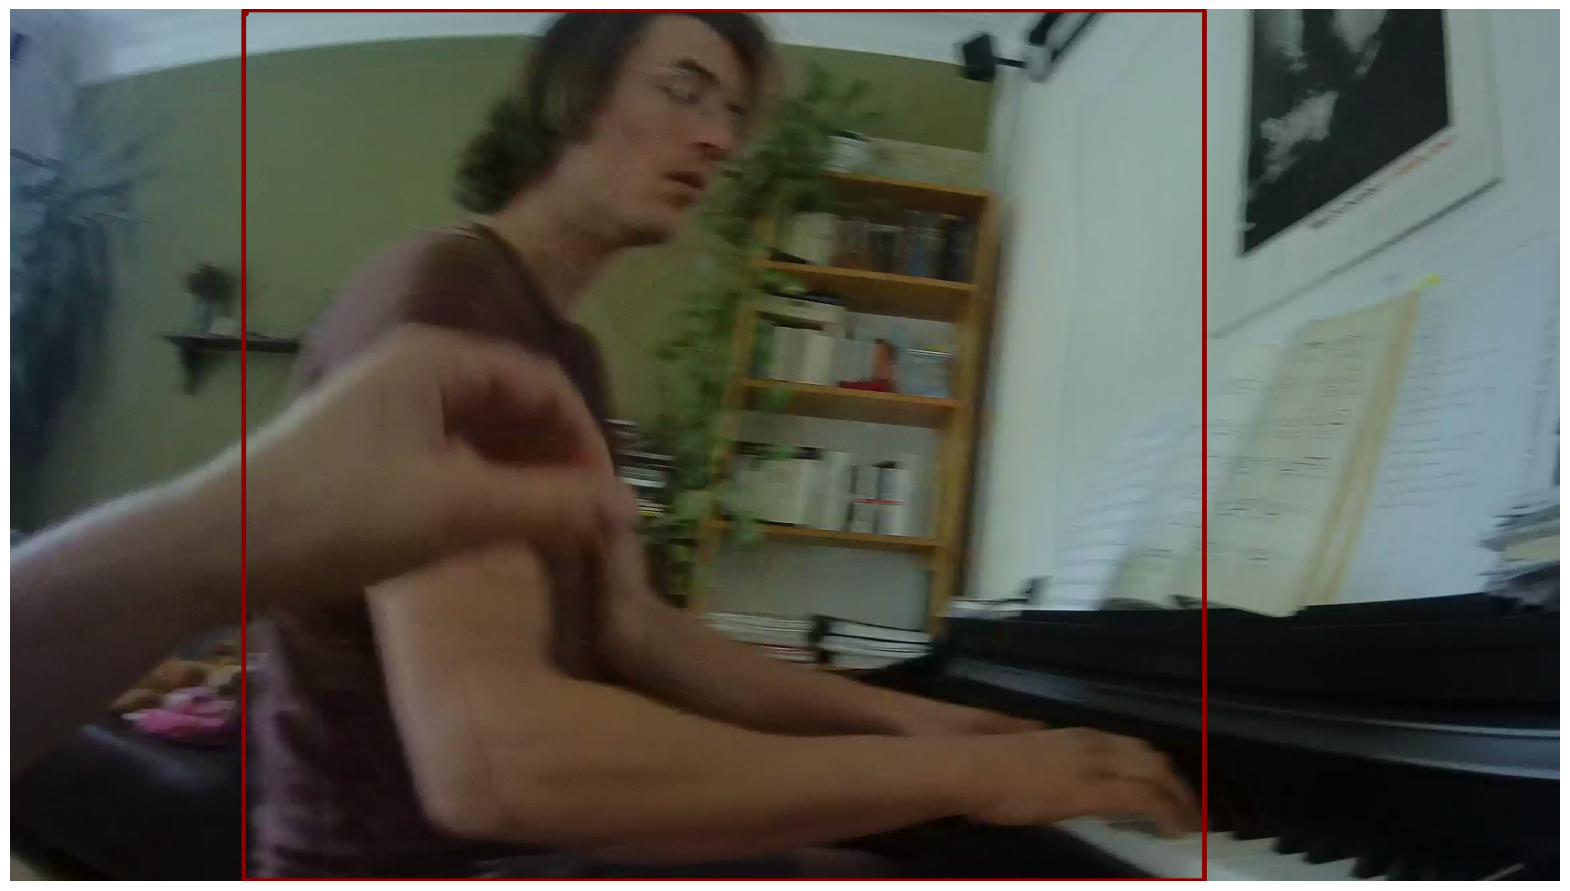

In [25]:
display_yolo_detections_with_proximity('quantex_at_home_id255237_2022_05_08_02_028320')